## 1.Setup

## 1.1 Install dependencies

In [15]:
!pip install tensorflow==2.19.0 opencv-python mediapipe scikit-learn matplotlib

## 1.2 import dependencies

In [13]:
import cv2
import os
import shutil
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
#import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Setup GPU growth

In [6]:
#Avoid out of memo errors by setting GPU memo consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
gpus

[]

## 1.4 Create folder structure

In [17]:
#setup paths
PSO_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [153]:
#make the directories
os.makedirs(PSO_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

## 2. Collect positives and anchors

## 2.1 untar labelled faces in the wild dataset

In [98]:
#Uncompress zip labelled faces in the wild
!tar -xf lfw.zip

In [19]:
#Move LFW images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [105]:
os.listdir('lfw')

['Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abbas_Kiarostami',
 'Abba_Eban',
 'Abdel_Aziz_Al-Hakim',
 'Abdel_Madi_Shabneh',
 'Abdel_Nasser_Assidi',
 'Abdoulaye_Wade',
 'Abdulaziz_Kamilov',
 'Abdullah',
 'Abdullah_Ahmad_Badawi',
 'Abdullah_al-Attiyah',
 'Abdullah_Gul',
 'Abdullah_Nasseef',
 'Abdullatif_Sener',
 'Abdul_Majeed_Shobokshi',
 'Abdul_Rahman',
 'Abel_Aguilar',
 'Abel_Pacheco',
 'Abid_Hamid_Mahmud_Al-Tikriti',
 'Abner_Martinez',
 'Abraham_Foxman',
 'Aby_Har-Even',
 'Adam_Ant',
 'Adam_Freier',
 'Adam_Herbert',
 'Adam_Kennedy',
 'Adam_Mair',
 'Adam_Rich',
 'Adam_Sandler',
 'Adam_Scott',
 'Adelina_Avila',
 'Adel_Al-Jubeir',
 'Adisai_Bodharamik',
 'Adolfo_Aguilar_Zinser',
 'Adolfo_Rodriguez_Saa',
 'Adoor_Gopalakarishnan',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',
 'Adrianna_Zuzic',
 'Adrian_Annus',
 'Adrian_Fernandez',
 'Adrian_McPherson',
 'Adrian_Murrell',
 'Adrian_Nastase',
 'Adrien_Brody',
 'Afton_S

## 2.2 Collect positive and anchor classes

In [21]:
#import uuid library to generate unique image names
import uuid

In [23]:
uuid.uuid1()

UUID('8bce86a9-5827-11f0-aadb-8282fdfb3b56')

In [25]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    #cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250,:]

    #Collect anchors
    if cv2.waitKey(10) & 0xFF == ord('a'):
        #create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write out anchor image
        cv2.imwrite(imgname, frame)

    #Collect positives
    if cv2.waitKey(10) & 0xFF == ord('p'):
        #create the unique file path
        imgname = os.path.join(PSO_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write out positive image
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)
    #Break gracefully
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

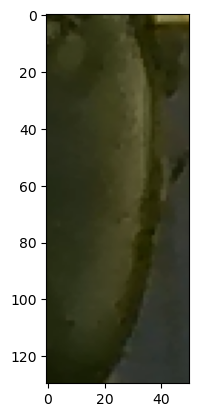

In [27]:
plt.imshow(frame[120:120+250,200:200+250,:])

In [29]:
frame.shape

(250, 250, 3)

## 3.Load and preprocess images

## 3.1 Get image directories

In [31]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(PSO_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [32]:
anchor.as_numpy_iterator().next()

b'data\\anchor\\ab93a697-567b-11f0-9a12-8282fdfb3b56.jpg'

## 3.2 Preprocessing - Scale size and Resize

In [35]:
def preprocess(file_path):
    #read in image from file path
    byte_img = tf.io.read_file(file_path)
    #load in the image
    img = tf.io.decode_jpeg(byte_img)
    #preprocessing step - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100, 100))
    #Scale image to be between 0 and 1
    img = img / 255.0
    return img

In [37]:
img = preprocess('data\\anchor\\a4122870-567b-11f0-ae63-8282fdfb3b56.jpg')

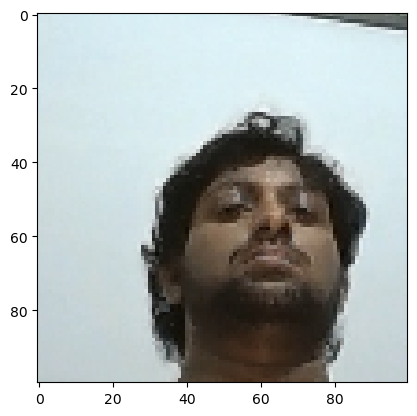

In [39]:
plt.imshow(img)

## 3.3 create labelled data set

In [181]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [41]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [43]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [45]:
example = data.as_numpy_iterator().next()

## 3.4 Build train and test partitions

In [48]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [50]:
res = preprocess_twin(*example)

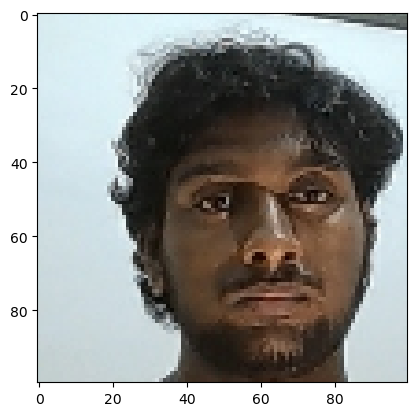

In [52]:
plt.imshow(res[1])

In [54]:
res[2]

1.0

In [56]:
#Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [58]:
samples = data.as_numpy_iterator().next()

In [60]:
len(samples)

3

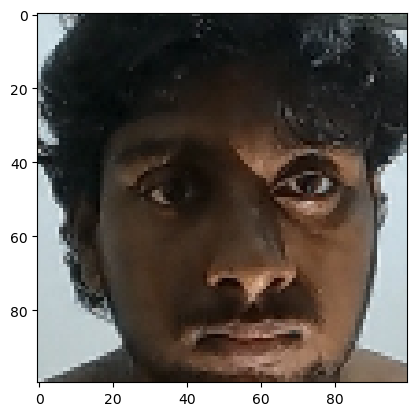

In [62]:
plt.imshow(samples[0])

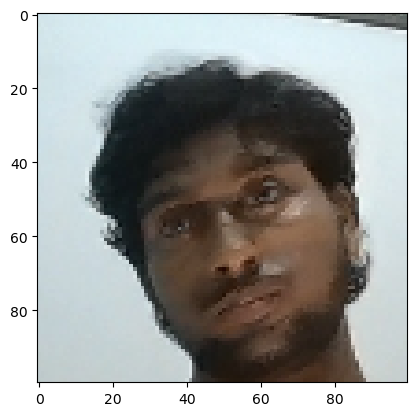

In [64]:
plt.imshow(samples[1])

In [66]:
samples[2]

1.0

In [68]:
#Training Partition
train_data = data.take(round(len(data)*7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [70]:
 train_samples = train_data.as_numpy_iterator()

In [72]:
len(train_samples.next()[0])

16

In [73]:
#Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## 4.Model Engineering

## 4.1 build embedding layer

In [78]:
inp = Input(shape = (100, 100, 3), name='input_image')

In [80]:
c1 = Conv2D(64, (10, 10), activation = 'relu')(inp)

In [82]:
m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

In [84]:
m1

<KerasTensor shape=(None, 46, 46, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1>

In [86]:
def make_embedding():
    inp = Input(shape = (100, 100, 3), name='input_image')

    #First block
    c1 = Conv2D(64, (10, 10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

    #Second block
    c2 = Conv2D(128, (7, 7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

    #Third block
    c3 = Conv2D(128, (4, 4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

    #Finale block
    c4 = Conv2D(256, (4, 4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation= 'sigmoid')(f1)

    return Model(inputs = [inp], outputs =[d1], name = 'embedding')

In [88]:
embedding = make_embedding()

In [90]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build distance layer

In [755]:
# #Siamese L1 Distance class
# class L1Dist(Layer):

#     #init method - inheritance
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)

#     #Similarity calculation
#     def call(self, input_embedding, validation_embedding):
#         return tf.math.abs(input_embedding - validation_embedding)

#     def compute_output_shape(self, input_shape):
#         # input_shape is a list/tuple of two shapes (they must match)
#         return input_shape[0]

In [92]:
#Siamese L1 Distance class
class L1Dist(tf.keras.layers.Layer):

     #init method - inheritance
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
     #Similarity calculation
    def call(self, input_embedding, validation_embedding):
        # if someone wrapped them in single‑element lists, unwrap here
        if isinstance(input_embedding, (list, tuple)):
            input_embedding = input_embedding[0]
        if isinstance(validation_embedding, (list, tuple)):
            validation_embedding = validation_embedding[0]
        return tf.math.abs(input_embedding - validation_embedding)

    def compute_output_shape(self, input_shape):
        # input_shape is a list/tuple of two shapes (they must match)
        return input_shape[0]


In [94]:
l1 = L1Dist()

In [96]:
l1

<L1Dist name=l1_dist, built=False>

## 4.3 Make siamese Model

In [99]:
input_image = Input(name='input_img', shape=(100, 100, 3))
validation_image = Input(name='validation_img', shape=(100, 100, 3))

In [101]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [103]:
siamese_layer = L1Dist()

In [105]:
distances = siamese_layer(inp_embedding, val_embedding)

In [119]:
classifier = Dense(1, activation='sigmoid')(distances)

In [109]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_14>

In [111]:
siamese_network = Model(inputs = [input_image, validation_image], outputs = classifier, name='SiameseNetwork')

In [113]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [123]:
def make_siamese_model():

    #anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))

    #validation image input in the network
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    #combined siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    #classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs = [input_image, validation_image], outputs = classifier, name='SiameseNetwork')

In [125]:
siamese_model = make_siamese_model()

In [127]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (None, 4096)              │               0 │ embedding[2][0],           │
│                               │                           │                 │ embedding[3][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## 5.Training

## 5.1 Setup loss and optimizer

In [131]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [133]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

## 5.2 Establish checkpoints

In [166]:
checkpoint_dir = './training_chechpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model) 

## 5.3 Build train Step function

In [136]:
test_batch = test_data.as_numpy_iterator()

In [138]:
batch_1 = test_batch.next()

In [140]:
len(batch_1)

3

In [142]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Unpack inputs and labels
        input_img, val_img = batch[:2]
        y = batch[2]  # assuming third element is the label

        # Forward pass
        yhat = siamese_model([input_img, val_img], training=True)

        # Compute loss
        loss = binary_cross_loss(y, yhat)

    print("Loss:", loss)

    # Backprop + update weights
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

## 5.4 Build training loop

In [144]:
def train(data, EPOCHS):
    #Loop through epochs
    for epoch in range (1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        #Loop through each batch
        for idx, batch in enumerate(data):
            #run train step here
            train_step(batch)
            progbar.update(idx+1)

        #Save checkpoint
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [147]:
EPOCHS = 50

In [226]:
train(train_data, EPOCHS)


 Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step

 Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step

 Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step

 Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step

 Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step

 Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step

 Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step

 Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step

 Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step

 Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 169s 4s/step

 Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step

 Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step

 Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step

 Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step

 Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step

 Epoch 16/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step

 Epoch 17/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 172s 5s/step

 Epoch 18/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 176s 5s/step

 Epoch 19/50
38/38 ━━━━━━━━━━━━━━━━━

## 6.Evaluate model

## 6.1 Import metrics

In [228]:
#Import metric calculation
from tensorflow.keras.metrics import Precision, Recall

## 6.2 make Prediction

In [231]:
#Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [233]:
test_var = test_data.as_numpy_iterator().next()

In [235]:
len(test_var)

3

In [237]:
#Make prediction
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[3.2806243e-12],
       [9.9883169e-01],
       [7.5088101e-06],
       [9.9986553e-01],
       [1.0000000e+00],
       [9.9977309e-01],
       [4.3515023e-09],
       [1.0000000e+00],
       [1.0000000e+00],
       [4.7121353e-06],
       [1.4011501e-04],
       [9.9994183e-01],
       [1.7029747e-07],
       [2.2731146e-13],
       [9.9999994e-01],
       [3.6011801e-11]], dtype=float32)

In [239]:
#Post processing the result
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0]

In [241]:
y_true

array([0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.],
      dtype=float32)

## 6.3 Calculating metrics

In [243]:
#creating a metric object
m = Recall()

#Calculating the recall value
m.update_state(y_true, y_hat)

#return result or recall 
m.result().numpy()

1.0

In [245]:
#creating a metric object
m = Precision()

#Calculating the recall value
m.update_state(y_true, y_hat)

#return result or recall 
m.result().numpy()

1.0

## 6.4 Viz Result

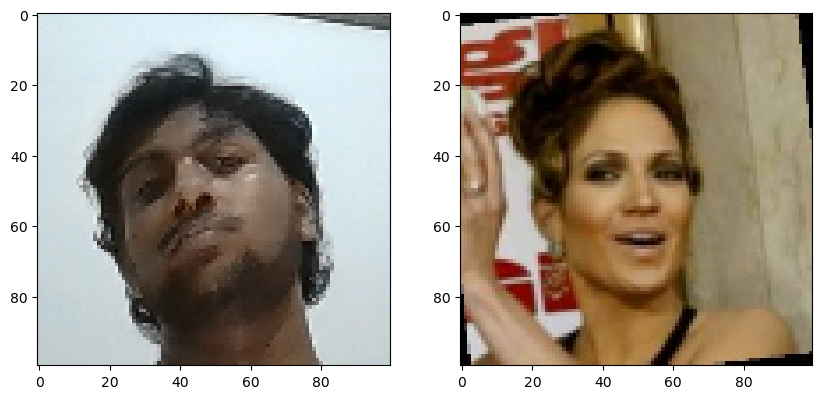

In [248]:
#Set plot size
plt.figure(figsize=(10, 8))

#set first subplot (use for show image side by side - Grid format)
plt.subplot(1, 2, 1)
plt.imshow(test_input[2])

#second subplot
plt.subplot(1, 2, 2)
plt.imshow(test_val[2])

#renders image clearly
plt.show()

## 7.Save model

In [190]:
#save weight
siamese_model.save('siamesemodel.h5')

In [801]:
#save weight in keras format
siamese_model.save('siamesemodel.keras')

In [303]:
#Reload model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy, 'binary_cross_loss': binary_cross_loss})

In [252]:
#make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[7.7407153e-10],
       [9.5804715e-01],
       [7.0479419e-04],
       [9.9769723e-01],
       [9.9997282e-01],
       [9.9918574e-01],
       [3.6065885e-08],
       [9.9999684e-01],
       [9.9999064e-01],
       [5.0368104e-05],
       [1.1812973e-06],
       [9.9996901e-01],
       [8.0067848e-06],
       [5.7804583e-10],
       [9.9999976e-01],
       [1.2526567e-05]], dtype=float32)

In [253]:
#View our model summery
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## 8.Real time test

## 8.1 Verification function

\application_data\verification_images

In [258]:
 os.listdir(os.path.join('application_data', 'verification_images'))

['b8e55eef-567b-11f0-911f-8282fdfb3b56.jpg',
 'b8f398dc-567b-11f0-8f55-8282fdfb3b56.jpg',
 'b901f45d-567b-11f0-a48a-8282fdfb3b56.jpg',
 'b90ff91f-567b-11f0-ba65-8282fdfb3b56.jpg',
 'b91e8463-567b-11f0-8eb1-8282fdfb3b56.jpg',
 'b925c6af-567b-11f0-ae4b-8282fdfb3b56.jpg',
 'b941b63f-567b-11f0-9744-8282fdfb3b56.jpg',
 'b95e3a9e-567b-11f0-b0d8-8282fdfb3b56.jpg',
 'b98fdeb5-567b-11f0-a791-8282fdfb3b56.jpg',
 'b99e3460-567b-11f0-9bb6-8282fdfb3b56.jpg',
 'b9ac516a-567b-11f0-be61-8282fdfb3b56.jpg',
 'b9c468a7-567b-11f0-832b-8282fdfb3b56.jpg',
 'b9f89fa1-567b-11f0-a97c-8282fdfb3b56.jpg',
 'b9ff9136-567b-11f0-8089-8282fdfb3b56.jpg',
 'ba439ff1-567b-11f0-b2aa-8282fdfb3b56.jpg',
 'bb0aeb2c-567b-11f0-af7b-8282fdfb3b56.jpg',
 'bb2008d8-567b-11f0-9b70-8282fdfb3b56.jpg',
 'bb4b6366-567b-11f0-83b0-8282fdfb3b56.jpg',
 'bb71912c-567b-11f0-ba08-8282fdfb3b56.jpg',
 'bc6ab07a-567b-11f0-948e-8282fdfb3b56.jpg',
 'bcf27b06-567b-11f0-8b0e-8282fdfb3b56.jpg',
 'bcf99de8-567b-11f0-80c8-8282fdfb3b56.jpg',
 'bd24040f

In [277]:
def verify(model, detection_threshold, verification_threshold):
    #Build result array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        #Make predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    #Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    #Verification threshold: Proportion of positive prediction / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [284]:
def verify(model, detection_threshold, verification_threshold):
    # collect all the individual prediction scores here
    results = []
    verification_dir = os.path.join('application_data', 'verification_images')
    input_path      = os.path.join('application_data', 'input_image', 'input_image.jpg')

    # preprocess your “anchor” once
    input_img = preprocess(input_path)
    # expand dims to make it a batch of 1
    input_batch = np.expand_dims(input_img, axis=0)

    for file in os.listdir(verification_dir):
        val_img = preprocess(os.path.join(verification_dir, file))
        val_batch = np.expand_dims(val_img, axis=0)

        # predict returns e.g. array([[0.37]], ...) for a batch of 1
        # verbose=0 silences the per‑call progress bar
        score = model.predict(
            [input_batch, val_batch],
            verbose=0
        )
        # extract the scalar out of shape (1,1)
        results.append(float(score[0][0]))

    # now count how many are above detection_threshold
    detections = np.sum(np.array(results) > detection_threshold)
    # fraction of positives
    verification = detections / len(results)
    verified = verification > verification_threshold

    return results, verified

## 8.2 OpenCV real time verification

In [347]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    frame = frame[120:120+250,200:200+250,:]

    cv2.imshow('Verification', frame)

    #Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        #run verification
        results, verified = verify(model, 0.8, 0.6)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False
False


In [345]:
DETECTION_THRESHOLD    = 0.8
VERIFICATION_THRESHOLD = 0.6
FONT                   = cv2.FONT_HERSHEY_SIMPLEX

cap = cv2.VideoCapture(0)

# For FPS calculation
prev_tick = cv2.getTickCount()

# To store the latest verification result and percentage
status_text  = None
status_color = (0, 0, 0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Crop to your ROI
    frame = frame[120:120+250, 200:200+250, :]

    # ─── Compute & draw FPS ────────────────────────────────────────────────────
    cur_tick = cv2.getTickCount()
    fps      = cv2.getTickFrequency() / (cur_tick - prev_tick)
    prev_tick = cur_tick
    cv2.putText(frame,
                f"{int(fps)} FPS",
                (10, 25),
                FONT,
                0.7,
                (0, 255, 0),
                2,
                cv2.LINE_AA)

    # ─── Draw last verification result (if any) ───────────────────────────────
    if status_text:
        h, w = frame.shape[:2]
        # semi‑transparent banner
        overlay = frame.copy()
        cv2.rectangle(overlay, (0, 0), (w, 40), status_color, -1)
        frame = cv2.addWeighted(overlay, 0.4, frame, 0.6, 0)
        # text
        cv2.putText(frame,
                    status_text,
                    (10, 30),
                    FONT,
                    0.8,
                    (255, 255, 255),
                    2,
                    cv2.LINE_AA)

    # ─── Show live feed ───────────────────────────────────────────────────────
    cv2.imshow('Verification', frame)

    key = cv2.waitKey(10) & 0xFF

    # ─── When user presses 'v', run verification ─────────────────────────────
    if key == ord('v'):
        # save the current ROI as the input image
        inp_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
        cv2.imwrite(inp_path, frame)

        # run your verify() function
        results, verified = verify(model, DETECTION_THRESHOLD, VERIFICATION_THRESHOLD)

        # compute average similarity percentage
        avg_pct = int(np.mean(results) * 100)

        # prepare status
        if verified:
            status_text  = f"{avg_pct}% VERIFIED"
            status_color = (0, 255, 0)
        else:
            status_text  = f"{avg_pct}% UNVERIFIED"
            status_color = (0, 0, 255)

    # ─── Quit on 'q' ──────────────────────────────────────────────────────────
    elif key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [299]:
np.squeeze(results) > 0.5

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [301]:
np.sum(np.squeeze(results) > 0.5)

47

In [339]:
cap.release()
cv2.destroyAllWindows()